# Support Vector Machine: Nonlinear Data


In this notebook we implement various SVM algorithms to classify a non-linear data set.

In general, for complex dataset, linear models **underfit** and we need to use complex models.

We can increase the complexity of a model by **augmenting the features**.

However, feature augmentation results into a high-dimensional feature space that slows down the training time.

To solve this efficiency issue, SVM uses **kernel trick**.

The kernel trick allows us to augment features without actually caculating them. As a consequence, the model can be trained faster. 

However, LinearSVC model doesn't suuport kernel trick.

The SVC model uses kernel trick on the dual optimization problem. We will see how to use the polynomial and Gaussian Radial Basis function (RBF) kernels. In the next notebook, we will investigate the optimal tuning of the Gaussian RBF kernel based SVM.

We will investigate the following SVM models.
- LinearSVC (on a linear model)
- LinearSVC (on a complex model with augemented features)
- Kernelized SVM
        -- SVC: Linear Kernel
        -- SVC: Polynomial Kernel
        -- SVC: Gaussian Radial Basis Function (RBF) Kernel

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import plotly.graph_objects as go


from sklearn.datasets.samples_generator import make_circles

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_curve, precision_recall_curve, classification_report
from sklearn.model_selection import train_test_split

# Function for Plotting Decision Boundary 


To better understand how Support Vector Machine classifier creates decision boundary, we need to **<font color=red size=6> visualize </font>** it.


We define the function "decision_boundary_svc_class_colored" to plot the decision boundary. 



In [2]:
def decision_boundary_svc_class_colored(clf, X, plotDistanceFromHyperplane=False, colorBar=False):
    
    # Get the min and max value of feature x1
    x1min, x1max = X[:,0].min() - 1, X[:, 0].max() + 1
    
    # Get the min and max value of feature x2
    x2min, x2max = X[:,1].min() - 1, X[:, 1].max() + 1
    
    # Create a mesh grid
    x1s = np.linspace(x1min, x1max, 100)
    x2s = np.linspace(x2min, x2max, 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    
    
    # Create pairs of new points from the grid
    X_new = np.c_[x1.ravel(), x2.ravel()]
    
    
    # Compute the class predictions for all new points
    y_pred = clf.predict(X_new).reshape(x1.shape)
    
    
    # Generate the contourf plot for the predictions
    plt.contourf(x1, x2, y_pred, cmap=plt.cm.bwr, alpha=0.2)
    
    
    if(plotDistanceFromHyperplane == True):
    
        # Compute the signed distance of a sample to the hyperplane for all new points
        y_decision = clf.decision_function(X_new).reshape(x1.shape)

        # Generate the contour plot for the distance of all points from the hyperplane and the two margins
        plt.contour(x1, x2, y_decision, levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'], colors='black')
        
        
        #plt.pcolormesh(x1, x2, -y_decision, cmap=plt.cm.RdBu)
        
        # Generate the contourf plot for the distance of all points from the hyperplane
        plt.contourf(x1, x2, y_decision, cmap=plt.cm.bwr, alpha=0.2)
    
    
    if(colorBar==True):
        plt.colorbar()   


# Synthetic Dataset

We will use Scikit-Learn's "datasets.make_circles" function to generate a synthetic non-linear dataset that is suitable for investigating classification (as well as clustering) models. It creates a large circle containing a smaller circle in 2d.

The following two parameters are used by the make_circles function:

- factor : Scale factor between inner and outer circle. Range 0 ~ 1.

- noise : Standard deviation of Gaussian noise added to the data.

## Load The Data and Visualiize 


We use the **matplotlib.pyplot.scatter** function which creates a scatter plot of y vs x with varying **marker size** and/or **color**.

The marker size and color are set by the parameters "s" and "c".

The color parameter "c" is assigned by "y" that represents the class labels. Thus, there would be two different colors (value of y) for this binary labeled dataset.


- c : color, sequence, or sequence of color, optional

        The marker color. Possible values:

            - A single color format string.
            - A sequence of color specifications of length n.
            - A sequence of n numbers to be mapped to colors using cmap and norm.
            - A 2-D array in which the rows are RGB or RGBA.
            
            
- s : scalar or array_like, shape (n, ), optional

        The marker size in points**2.

            
            
- cmap : Colormap, optional, default: None

        A Colormap instance or registered colormap name. cmap is only used if c is an array of floats. If None, defaults to rc image.cmap.

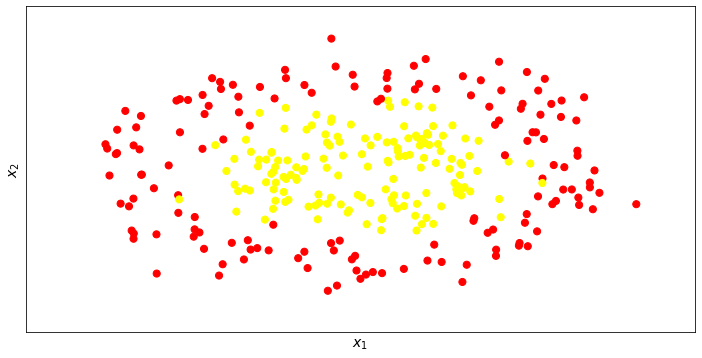

In [3]:
X, y = make_circles(300, factor=0.4, noise=0.15)

label = y

plt.figure(figsize=(12, 6))

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')

#plt.title("Data Distribution", fontsize=16)
plt.xlabel("$x_1$", fontsize=14)
plt.ylabel("$x_2$", fontsize=14)
plt.axis([-1.5, 1.5, -1.7, 1.7])
plt.xticks(())
plt.yticks(())
plt.show()

## Split Data into Train-Test Set

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

## Create A Scatter Plot of Train and Test Data  

On the same figure we plot both the train and test data. 

To separately show the test data, we use black "edgecolors" and slightly bigger marker size (using the "s" parameter).

More info on the parameters of matplotlib scatter plot.

https://matplotlib.org/api/_as_gen/matplotlib.pyplot.scatter.html

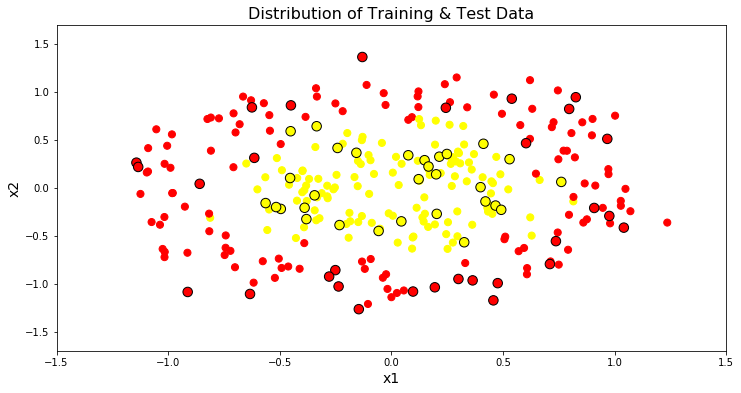

In [5]:
plt.figure(figsize=(12, 6))

plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=50, cmap='autumn')
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=90, cmap='autumn', alpha=1.0, edgecolors="k")

plt.title("Distribution of Training & Test Data", fontsize=16)
plt.xlabel("x1", fontsize=14)
plt.ylabel("x2", fontsize=14)
plt.axis([-1.5, 1.5, -1.7, 1.7])
plt.show()

## LinearSVC

First we train a **linear model** using LinearSVC.

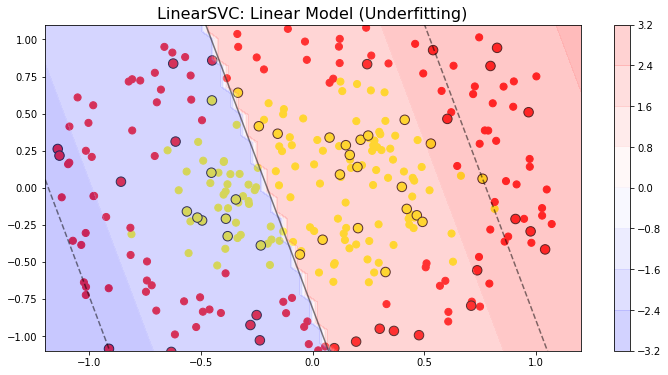

Training Accuracy:  0.5791666666666667
Test Accuracy:  0.55

Test Confusion Matrix:
[[12 18]
 [ 9 21]]

Test Precision = 0.538462
Test Recall = 0.700000
Test F1 Score = 0.608696

Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.40      0.47        30
           1       0.54      0.70      0.61        30

    accuracy                           0.55        60
   macro avg       0.55      0.55      0.54        60
weighted avg       0.55      0.55      0.54        60



In [6]:
scaler = StandardScaler()

svm_clf = LinearSVC(C=1, loss="hinge", random_state=42, max_iter=5000)

scaled_svm_clf = Pipeline([
        ("scaler", scaler),
        ("linear_svc", svm_clf),
    ])


scaled_svm_clf.fit(X, y)

y_train_predicted = scaled_svm_clf.predict(X_train)



plt.figure(figsize=(12, 6))
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=50, cmap='autumn')
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=90, cmap='autumn', alpha=1.0, edgecolors="k")
decision_boundary_svc_class_colored(scaled_svm_clf, X, plotDistanceFromHyperplane=True, colorBar=True)
plt.title("LinearSVC: Linear Model (Underfitting)", fontsize=16)
plt.axis([-1.2, 1.2, -1.1, 1.1])
plt.show()


print("Training Accuracy: ", scaled_svm_clf.score(X_train, y_train))
y_test_predicted = scaled_svm_clf.predict(X_test)



print("Test Accuracy: ", scaled_svm_clf.score(X_test, y_test))

print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))


precision_test = precision_score(y_test, y_test_predicted) 
print("\nTest Precision = %f" % precision_test)

recall_test = recall_score(y_test, y_test_predicted)
print("Test Recall = %f" % recall_test)


f1_test = f1_score(y_test, y_test_predicted)
print("Test F1 Score = %f" % f1_test)


print("\nClassification Report:")
print(classification_report(y_test, y_test_predicted))

## Observation: Linear Model

For the non-linear dataset, the LinearSVC "linear" model will always **underfit**.

We have to increase the complexity of the model by augmenting the features.


# Linear Separation of Non-Linear Data: Feature Augmentation

First let's get an intuitive understanding of the feature augmentation process. Particularly we will see how it shakes off the data points to separate them in a high-dimensional space.

## Visual Understanding of Feature Augmentation  


We create an interactive 3D representation of the 2 features and their combined quadratic term by using **Plotly Express**. It is a high-level Python visualization library and a a wrapper for Plotly.py.

https://plot.ly/

We need to install plotly first.

        pip install plotly==4.2.1
        
We use **go.Scatter3D** from plotly.graph_objs. Like the 2D scatter plot go.Scatter, go.Scatter3d plots individual data in three-dimensional space.

We observe how the features are separated in two classes in the 3D (augmented) feature space.

In [7]:
z = np.exp(-(X ** 2).sum(1))

fig = go.Figure(data=[go.Scatter3d(
    x=X[:, 0],
    y=X[:, 1],
    z=z,
    mode='markers',
    marker=dict(
        size=5,
        color=label,                # set color to an array/list of desired values
        colorscale='Viridis',       # choose a colorscale
        opacity=0.9
    )
)])


fig.update_layout(scene = dict(
                    xaxis_title='x1',
                    yaxis_title='x2',
                    zaxis_title='phi(x)'),
                    width=700,
                    margin=dict(r=0, b=0, l=0, t=0))
fig.show()


## LinearSVC: Polynomial Model

To create a complex model we will add polynomial features. However, we need to choose the optimal polynomial model (degree of the polynomial).

### Model Selection: Optimal Polynomial Degree

We will choose the optimal polynomial model as follows.

        -- Split the training data into training and validation fold (80%-20%). Vary the degree of the polynomial and train the SVM model using the training fold data. Then, compute the accuracy (use the "score" function) for the validation fold data using the models with varying degree. Finally, plot the accuracy values against the varying degree. From this plot find the optimal degree (that gives the highest validation fold accuracy).

### Split Training data into Traing and Validation Fold

In [8]:
X_train_fold, X_val_fold, y_train_fold, y_val_fold = train_test_split(X_train, y_train, test_size=0.20, random_state=42)

### Model Selection: Optimal Polynomial Degree

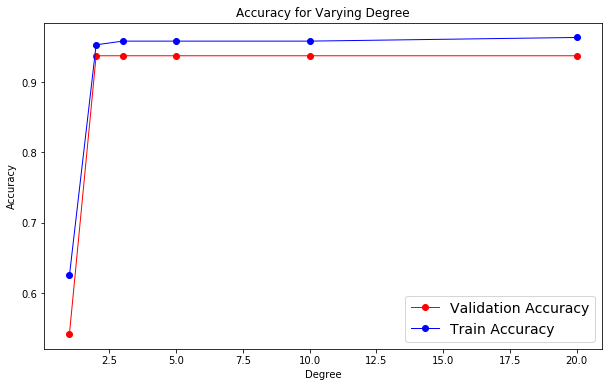

Optimal Degree:  2


CPU times: user 913 ms, sys: 29.6 ms, total: 943 ms
Wall time: 279 ms


In [9]:
%%time

degreeList = [1, 2, 3, 5, 10, 20]

accuracy_train, accuracy_val = [], []

for degree in degreeList:
    
    model = make_pipeline(PolynomialFeatures(degree, include_bias=False), StandardScaler(), 
                          LinearSVC(C=1, loss="hinge", random_state=42)) 
  
    model.fit(X_train_fold, y_train_fold)
       
    # Make prediction 
    y_train_predicted = model.predict(X_train_fold)
    y_val_predicted = model.predict(X_val_fold)
    
    
    accuracy_train.append(model.score(X_train_fold, y_train_fold))
    accuracy_val.append(model.score(X_val_fold, y_val_fold))
    

plt.figure(figsize=(10, 6))   
plt.plot(degreeList, accuracy_val, "ro-", alpha=1.0, linewidth=1.0, label="Validation Accuracy")
plt.plot(degreeList, accuracy_train, "bo-", alpha=1.0, linewidth=1.0, label="Train Accuracy")  

plt.legend(loc="best", fontsize=14) 
plt.xlabel("Degree")
plt.ylabel("Accuracy")
plt.title("Accuracy for Varying Degree")
plt.show()



# Find the value of degree that gives max validation accuracy
j = 0
max_val_accuracy = accuracy_val[j]
optimal_degree = 1

for i in degreeList:
    if(accuracy_val[j] > max_val_accuracy):
        max_val_accuracy = accuracy_val[j]
        optimal_degree = i
    j +=1
    
print("Optimal Degree: ", optimal_degree)
print("\n")

## Train the Optimal Polynomial Model


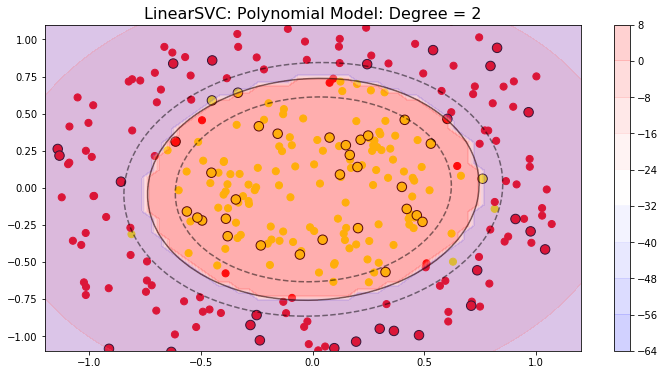

Training Accuracy:  0.9541666666666667
Test Accuracy:  0.9333333333333333

Test Confusion Matrix:
[[29  1]
 [ 3 27]]

Test Precision = 0.964286
Test Recall = 0.900000
Test F1 Score = 0.931034

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.97      0.94        30
           1       0.96      0.90      0.93        30

    accuracy                           0.93        60
   macro avg       0.94      0.93      0.93        60
weighted avg       0.94      0.93      0.93        60



In [10]:
# Variable that speficies the degree of the polynomial to be added to the feature vector
optimal_poly_degree = optimal_degree


scaled_svm_clf = Pipeline([
        ("poly_features", PolynomialFeatures(degree=optimal_poly_degree)),
        ("scaler", StandardScaler()),
        ("clf", LinearSVC(C=1, loss="hinge", random_state=42))
    ])


scaled_svm_clf.fit(X, y)

y_train_predicted = scaled_svm_clf.predict(X_train)



plt.figure(figsize=(12, 6))
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=50, cmap='autumn')
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=90, cmap='autumn', alpha=1.0, edgecolors="k")
decision_boundary_svc_class_colored(scaled_svm_clf, X, plotDistanceFromHyperplane=True, colorBar=True)
plt.title("LinearSVC: Polynomial Model: Degree = %d" % optimal_poly_degree, fontsize=16)
plt.axis([-1.2, 1.2, -1.1, 1.1])
plt.show()



print("Training Accuracy: ", scaled_svm_clf.score(X_train, y_train))

y_test_predicted = scaled_svm_clf.predict(X_test)
print("Test Accuracy: ", scaled_svm_clf.score(X_test, y_test))


print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))


precision_test = precision_score(y_test, y_test_predicted) 
print("\nTest Precision = %f" % precision_test)

recall_test = recall_score(y_test, y_test_predicted)
print("Test Recall = %f" % recall_test)


f1_test = f1_score(y_test, y_test_predicted)
print("Test F1 Score = %f" % f1_test)


print("\nClassification Report:")
print(classification_report(y_test, y_test_predicted))

# Limitation: LinearSVC Polynomial Model

The LinearSVC model uses **Coordinate Descent** algorithm. It scales linearly with the training data and features: $O(Nd)$. 

However, it **performs poorly if augmented feature space is very large**.

For high-dimensional data (augmented feature space), Kernelized SVM models scale efficiently.

# Kernelized SVM


The kernelized SVM uses a **magical** mathematical technique called the **kernel trick**. 

The kernel trick makes it possible to get the same result as if we added many polynomial features, even with very high-degree polynomials, without actually having to add them. So there is no combinatorial explosion of the number of features since we don’t actually add any features. 

This trick is implemented by the SVC class. 

We will investigate 3 kernels.
- Linear
- Polynomial
- Gaussian Radial Basis Function (RBF)

## SVC: Linear Kernel

The linear kernel based SVC is similar to LinearSVC model. It **underfits** non-linear data. It's not as flexible as the LinearSVC.

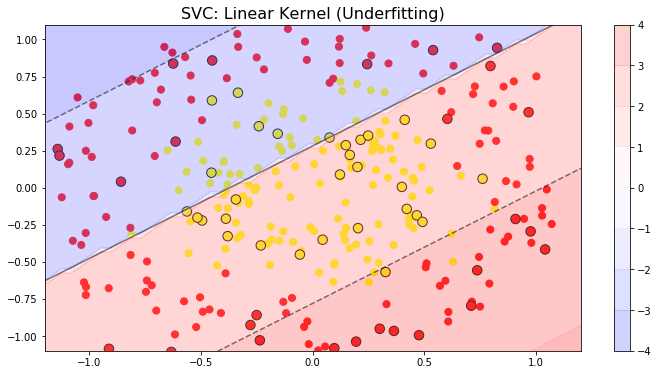

Training Accuracy:  0.5875
Test Accuracy:  0.5833333333333334

Test Confusion Matrix:
[[10 20]
 [ 5 25]]

Test Precision = 0.555556
Test Recall = 0.833333
Test F1 Score = 0.666667

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.33      0.44        30
           1       0.56      0.83      0.67        30

    accuracy                           0.58        60
   macro avg       0.61      0.58      0.56        60
weighted avg       0.61      0.58      0.56        60



In [11]:
svc_clf = SVC(kernel='linear').fit(X_train, y_train)

svc_clf.fit(X_train, y_train)

y_train_predicted = svc_clf.predict(X_train)


plt.figure(figsize=(12, 6))
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=50, cmap='autumn')
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=90, cmap='autumn', alpha=1.0, edgecolors="k")
decision_boundary_svc_class_colored(svc_clf, X, plotDistanceFromHyperplane=True, colorBar=True)
plt.title("SVC: Linear Kernel (Underfitting)", fontsize=16)
plt.axis([-1.2, 1.2, -1.1, 1.1])
plt.show()




print("Training Accuracy: ", svc_clf.score(X_train, y_train))
y_test_predicted = svc_clf.predict(X_test)
print("Test Accuracy: ", svc_clf.score(X_test, y_test))


print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))


precision_test = precision_score(y_test, y_test_predicted) 
print("\nTest Precision = %f" % precision_test)

recall_test = recall_score(y_test, y_test_predicted)
print("Test Recall = %f" % recall_test)


f1_test = f1_score(y_test, y_test_predicted)
print("Test F1 Score = %f" % f1_test)


print("\nClassification Report:")
print(classification_report(y_test, y_test_predicted))

## SVC: Polynomial Kernel


We can add polynomial features by using the polynomial kernel. 

However, we need to choose the optimal polynomial model (degree of the polynomial).


### Model Selection: Optimal Polynomial Degree

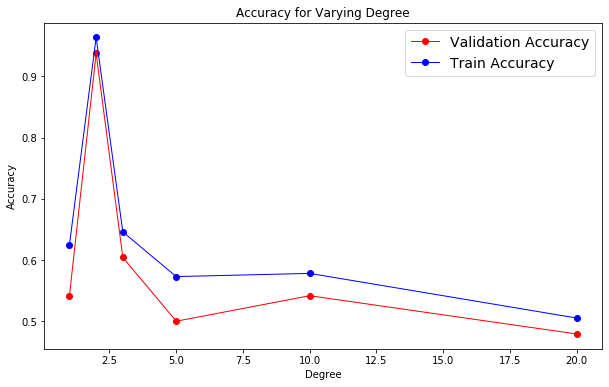

Optimal Degree:  2


CPU times: user 241 ms, sys: 7.29 ms, total: 248 ms
Wall time: 250 ms


In [12]:
%%time

degreeList = [1, 2, 3, 5, 10, 20]

accuracy_train, accuracy_val = [], []

for degree in degreeList:
    
    model = SVC(C=10, kernel='poly', degree=degree, gamma='auto')
  
    model.fit(X_train_fold, y_train_fold)
       
    # Make prediction 
    y_train_predicted = model.predict(X_train_fold)
    y_val_predicted = model.predict(X_val_fold)
    
    
    accuracy_train.append(model.score(X_train_fold, y_train_fold))
    accuracy_val.append(model.score(X_val_fold, y_val_fold))
      

plt.figure(figsize=(10, 6))   
plt.plot(degreeList, accuracy_val, "ro-", alpha=1.0, linewidth=1.0, label="Validation Accuracy")
plt.plot(degreeList, accuracy_train, "bo-", alpha=1.0, linewidth=1.0, label="Train Accuracy")  

plt.legend(loc="best", fontsize=14) 
plt.xlabel("Degree")
plt.ylabel("Accuracy")
plt.title("Accuracy for Varying Degree")
plt.show()


# Find the value of degree that gives max validation accuracy
j = 0
max_val_accuracy = accuracy_val[j]
optimal_degree = 1

for i in degreeList:
    if(accuracy_val[j] > max_val_accuracy):
        max_val_accuracy = accuracy_val[j]
        optimal_degree = i
    j +=1
    
print("Optimal Degree: ", optimal_degree)
print("\n")

## Train the Optimal Polynomial Model

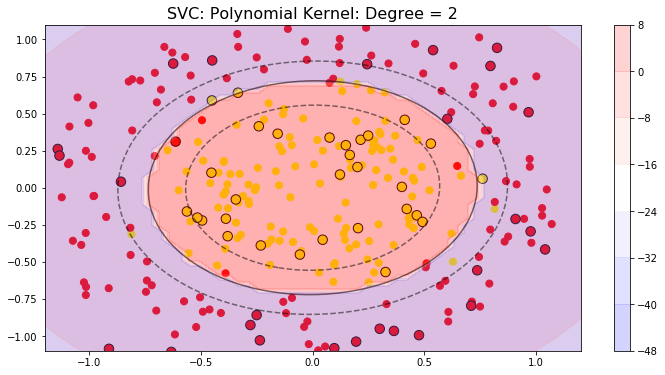

Training Accuracy:  0.9583333333333334
Test Accuracy:  0.9333333333333333

Test Confusion Matrix:
[[29  1]
 [ 3 27]]

Test Precision = 0.964286
Test Recall = 0.900000
Test F1 Score = 0.931034

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.97      0.94        30
           1       0.96      0.90      0.93        30

    accuracy                           0.93        60
   macro avg       0.94      0.93      0.93        60
weighted avg       0.94      0.93      0.93        60



In [13]:
optimalDegree = optimal_degree

svc_clf = SVC(C = 10, kernel='poly', degree=optimalDegree, gamma='auto').fit(X_train, y_train)

svc_clf.fit(X_train, y_train)


y_train_predicted = svc_clf.predict(X_train)


plt.figure(figsize=(12, 6))
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=50, cmap='autumn')
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=90, cmap='autumn', alpha=1.0, edgecolors="k")
decision_boundary_svc_class_colored(svc_clf, X, plotDistanceFromHyperplane=True, colorBar=True)
plt.title("SVC: Polynomial Kernel: Degree = %d" % optimalDegree, fontsize=16)
plt.axis([-1.2, 1.2, -1.1, 1.1])
plt.show()



print("Training Accuracy: ", svc_clf.score(X_train, y_train))
y_test_predicted = svc_clf.predict(X_test)

print("Test Accuracy: ", svc_clf.score(X_test, y_test))

print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))


precision_test = precision_score(y_test, y_test_predicted) 
print("\nTest Precision = %f" % precision_test)

recall_test = recall_score(y_test, y_test_predicted)
print("Test Recall = %f" % recall_test)


f1_test = f1_score(y_test, y_test_predicted)
print("Test F1 Score = %f" % f1_test)


print("\nClassification Report:")
print(classification_report(y_test, y_test_predicted))

## SVC: Gaussian Radial Basis Function (RBF) Kernel

An alternative way to add features is to use a **similarity function**.

It measures how much each instance resembles a particular landmark. 

We use the Gaussian Radial Basis Function (RBF) as the similarity function to augment features.

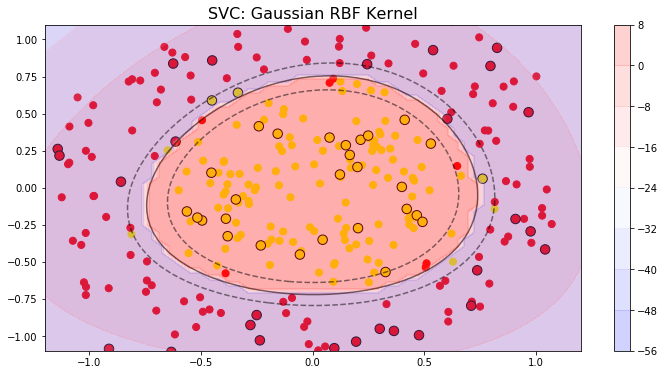

Training Accuracy:  0.9541666666666667
Test Accuracy:  0.95

Test Confusion Matrix:
[[30  0]
 [ 3 27]]

Test Precision = 1.000000
Test Recall = 0.900000
Test F1 Score = 0.947368

Classification Report:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95        30
           1       1.00      0.90      0.95        30

    accuracy                           0.95        60
   macro avg       0.95      0.95      0.95        60
weighted avg       0.95      0.95      0.95        60



In [14]:
svm_rbf_clf = SVC(kernel="rbf", gamma=0.1, C=1000)

svm_rbf_clf.fit(X_train, y_train)

y_train_predicted = svm_rbf_clf.predict(X_train)

plt.figure(figsize=(12, 6))
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=50, cmap='autumn')
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=90, cmap='autumn', alpha=1.0, edgecolors="k")
decision_boundary_svc_class_colored(svm_rbf_clf, X, plotDistanceFromHyperplane=True, colorBar=True)
plt.title("SVC: Gaussian RBF Kernel", fontsize=16)
plt.axis([-1.2, 1.2, -1.1, 1.1])
plt.show()


print("Training Accuracy: ", svm_rbf_clf.score(X_train, y_train))
y_test_predicted = svm_rbf_clf.predict(X_test)
print("Test Accuracy: ", svm_rbf_clf.score(X_test, y_test))

print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))

precision_test = precision_score(y_test, y_test_predicted) 
print("\nTest Precision = %f" % precision_test)

recall_test = recall_score(y_test, y_test_predicted)
print("Test Recall = %f" % recall_test)

f1_test = f1_score(y_test, y_test_predicted)
print("Test F1 Score = %f" % f1_test)

print("\nClassification Report:")
print(classification_report(y_test, y_test_predicted))

## Observation: Gaussian RBF Kernel


The Gaussian RBF kernel based SVM works well on small and medium sized complex data set. 

However, it needs to be **tuned well**. Specially the fine tuning of the hyperparameters $\gamma$ and $C$ is essential for optimal performance. We need to understand well how these two parameters influence the performance of the Gaussian RBF based SVM. 

Let's turn to the next notebook for this exciting investigation.